# Phase-field approach to brittle fracture
$\newcommand{\bvarepsilon}{\boldsymbol{\varepsilon}}
\newcommand{\dx}{\,\text{dx}}
\newcommand{\dev}{\operatorname{dev}}
\newcommand{\tr}{\operatorname{tr}}
\DeclareMathOperator*{\argmin}{arg min}$

The present demo illustrates how multi-physics problems can be coupled and solved in a staggered fashion. This problematic is illustrated on a phase-field approach to brittle fracture in which two different mechanical problems are involved:

* a displacement problem ($u$-problem) involving a non-linear elastic constitutive model at fixed damage which includes unilateral conditions forbidding crack evolution under compressive states

* a damage problem ($d$-problem) including a damage gradient term associated with a regularization length $\ell_0$ which is at the basis of the phase-field approach to fracture

> Note that for the sake of simplicity, the damage problem considered in this demo is in fact a linear problem and could, therefore, well be formulated directly with FEniCS. We will however implement it as a `MFrontNonlinearProblem` to show how information can be exchanged between both problems. Besides, more advanced numerical implementations of the phase-field method involve damage problems which are indeed non-linear.

The problem is that of a stiff circular inclusion embedded in a square plate under imposed vertical displacement on its top surface [@bourdin2000numerical]. Zero Dirichlet boundary conditions will be enforced for the damage field on the inclusion boundary.

<p align="center">
<img src="phase_field.gif" width="300">
</p>

## Introduction on phase-field approaches to brittle fracture

The phase-field approach to brittle fracture originates from the mathematical regularization of Francfort \& Marigo variational approach of fracture [@francfort1998revisiting]. Following mathematical works of [@ambrosio1990approximation], the regularization proposed by [@bourdin2000numerical] relies on the following total energy $\mathcal{E}(u, d) = \mathcal{E}_\text{pot}(u,d)+\mathcal{E}_\text{frac}(d)$ where the potential and fracture energies respectively read as:


\begin{align*}
\mathcal{E}_\text{pot}(u,d) &= \int_\Omega g(d)\dfrac{1}{2}\bvarepsilon:\mathbb{C}:\bvarepsilon \dx - W_{ext}(u) \\
\mathcal{E}_\text{frac}(d) &= \dfrac{G_c}{c_w} \int_{\Omega}\left( \frac{w(d)}{\ell_0} + \ell_0 \|\nabla d\|^2 \right)\dx
\end{align*}

in which 

* $u$ is the displacement field and $W_{ext}(u)$ is the work of external forces
* $d\in[0;1]$ is a continuous field representing the fracture location ($d=1$) in a *smeared* fashion
* $\ell_0$ is a small regularization length-scale parameter
* $g(d)$ is continuous strictly-decreasing degradation function
* $w(d)$ a continuous strictly-increasing function
* $c_w$ a numerical constant associated with $w$

> This formulation exhibits extremely strong links with damage gradient models [@pham2011gradient] so that $d$ is often referred to as a damage variable.

Solutions to the quasi-static evolution at discrete time steps $(u_n,d_n)$ are obtained from a global energy minimum principle on both variables with an additional irreversibility constraint $d_n\geq d_{n-1}$ for the damage variable.

This original formulation does not distinguish between tensile and compressive stress states, yielding spurious crack formation in compressive regions. A commonly used remedy consists in splitting the energy density $\psi$ into a positive (associated with tension states) and negative (compressive states) part and apply the degradation function only on the positive part i.e.:

$$
\mathcal{E}_{pot}(u,d) = \int_\Omega \left(g(d)\psi^+(\bvarepsilon)+\psi^-(\bvarepsilon)\right) \dx - W_{ext}(u)
$$

Different choices of this splitting exist and we use in this demo the volumetric/deviatoric splitting introduced in [@amor2009regularized]:

$$ \begin{align*}
\psi^+(\bvarepsilon) &= \dfrac{1}{2}\kappa \langle \tr(\bvarepsilon)\rangle_+^2 + \mu  \dev(\bvarepsilon):\dev(\bvarepsilon)\\
\psi^-(\bvarepsilon) &= \dfrac{1}{2}\kappa \langle \tr(\bvarepsilon)\rangle_-^2
\end{align*}
$$
where $\langle \star \rangle_\pm$ denotes the positive/negative part function, $\dev$ is the deviatoric operator and $\kappa=\lambda+\dfrac{2}{3}\mu$ stands for the compression modulus. Note that we also provide an implementation of the spectral splitting introduced by [@miehe2010phase] in the [`PhaseFieldDisplacementSpectralSplit.mfront` file](https://gitlab.enpc.fr/navier-fenics/mgis-fenics-demos/blob/master/demos/phase_field/PhaseFieldDisplacementSpectralSplit.mfront).

A classical choice for the degradation function is $g(d)=(1-d)^2 + k_\text{res}$ where $k_\text{res} \ll 1$ is a residual stiffness avoiding singular stiffness in the fully damaged state.  
As regards the fracture energy density, two choices originating from the work of Ambrosio and Tortorelli (AT) are widely used, namely:

$$
\begin{align*}
\text{AT2 model:} \quad & w(d) = d^2, \quad c_w=2\\
\text{AT1 model:} \quad & w(d) = d, \quad c_w=\dfrac{8}{3}
\end{align*}
$$
in which the constant $c_w$ is chosen so that analytical localized solution profiles correspond to a dissipated precisely equal to $G_c$. 

In this demo we will use the AT2 model.


## Numerical resolution techniques

A classical approach for computing the solution at load increment $n$ is to resort to a so-called *alternate minimization* scheme which involves the following steps embedded in an iterative procedure:

\begin{align}
u^k &= \argmin_u \mathcal{E}(u, d^{k-1}) \tag{$u$-problem}\\
d^k &= \argmin_{d \text{ s.t. } d_{n-1} \leq d} \mathcal{E}(u^k, d) \tag{$d$-problem}
\end{align}
until convergence.

The first step ($u$-problem) of this staggered solution scheme therefore involves solving the following non-linear mechanical problem at fixed damage:

$$
\textrm{Find } u\in V_u \text{ s.t. } \int_\Omega \boldsymbol{\sigma}(u,d_{k-1}):\operatorname{sym}\nabla \widehat{u} \,\text{dx} = W_{ext}(\widehat{u}) \quad \forall \widehat{u}\in V_u
$$

with $\boldsymbol{\sigma}(u,d)=g(d)\dfrac{\partial \psi^+}{\partial \bvarepsilon}(u)+\dfrac{\partial \psi^-}{\partial \bvarepsilon}(u)$.

The second step ($d$-problem) amounts to solving a variational inequality problem due to the presence of the irreversibility constraint $d_{n-1} \leq d$. A simple way of enforcing, implicitly, this irreversibility constraint has been proposed in [@miehe2010phase] by resorting to a so-called *history function* which correspond to the maximal value of the tensile energy density $\psi^+$ over the past loading history:

$$
H = \max_{m \leq n}\{\psi^+(\bvarepsilon_m)\}
$$

Technically, the irreversibility constraint is dropped and the current tensile energy $\psi^+$ is substituted by $H$ in the $d$-problem. The optimality condition therefore yields the following variational problem:

$$
\textrm{Find } d\in V_d \text{ s.t. } \int_\Omega \left(g'(d)H\widehat{d}+\dfrac{G_c}{\ell_0c_w}\left(w'(d)\widehat{d} + 2\ell_0^2 \nabla d \cdot \nabla \widehat{d}\right)\right) \,\text{dx} = 0 \quad \forall \widehat{d}\in V_d  
$$

> Note that this approach loses the original variational for of the phase-field formulation. In particular, no theoretical results establishing the equivalence with the original constrained minimization problem exist. This approach is however widespread due to its simplicity.

## MFront behaviour for the displacement problem

For the retained choice of models, the stress/strain constitutive equation at fixed damage reads as:

$$
\boldsymbol{\sigma}(\bvarepsilon,d)=((1-d)^2+k_\text{res})\left(\kappa \langle \tr(\bvarepsilon)\rangle_+\textbf{I} + 2\mu \dev(\bvarepsilon)\right)+\kappa \langle \tr(\bvarepsilon)\rangle_- \textbf{I}
$$

The stress is here explicitly computed from the strain (as in the [non-linear heat transfer demo](https://thelfer.github.io/mgis/web/mgis_fenics_nonlinear_heat_transfer.html)) so that we use the `DefaultDSL`. Material properties are defined, the history function and positive energy density are decleared as (internal) state variables whereas the damage field is declared as an external state variable.

```cpp
@DSL DefaultDSL;
@Author Jérémy Bleyer, Thomas Helfer;
@Date 08 / 04 / 2020;
@Behaviour PhaseFieldDisplacementDeviatoricSplit;

@MaterialProperty stress Yg;
Yg.setGlossaryName("YoungModulus");
@MaterialProperty real ν;
ν.setGlossaryName("PoissonRatio");

@Parameter real kres = 1e-6;
kres.setEntryName("ResidualStiffness");

@StateVariable real H;
H.setEntryName("HistoryFunction");

@StateVariable real Ψ₊;
Ψ₊.setEntryName("PositiveEnergyDensity");

@ExternalStateVariable real d;
d.setGlossaryName("Damage");
```

We now write the behaviour and provide consistent tangent operators for the problem at fixed damage i.e. the tangent operator is actually the secant operator for the coupled $(u,d)$ problem.

```cpp
@ProvidesSymmetricTangentOperator;
@Integrator {
  // update the damage
  const auto d_ = d + dd;
  // lame coefficients
  const auto λ = computeLambda(Yg, ν);
  const auto μ = computeMu(Yg, ν);
  // compression modulus
  const auto κ = λ + 2 / 3 ⋅ μ;
  // computation of the stress, positive energy density and consistent
  // tangent operator
  const auto ε = eval(eto + deto);
  const auto tr = trace(ε);
  const auto εᵈ = deviator(ε);
  // energy density
  const auto tr_p = max(tr, strain(0));
  const auto tr_n = tr - tr_p;
  Ψ₊ = (κ / 2) ⋅ (tr_p) ⋅ (tr_p) + μ ⋅ (εᵈ | εᵈ);
  // history function
  H = max(H, Ψ₊);
  // degradation function
  const auto gᵈ = (1 - d_) ⋅ (1 - d_) + kres; 
  // stress
  σ = κ ⋅ (gᵈ ⋅ tr_p + tr_n) ⋅ I₂ + 2 ⋅ μ ⋅ gᵈ ⋅ εᵈ;
  // consistent tangent operator (secant one here)
  if (computeTangentOperator_) {
    static_cast<void>(smt);
    if (tr >= 0) {
      ∂σ∕∂Δεᵗᵒ = gᵈ ⋅ (κ ⋅ (I₂ ⊗ I₂) + 2 ⋅ μ ⋅ Stensor4::K());
    } else {
      ∂σ∕∂Δεᵗᵒ = κ ⋅ (I₂ ⊗ I₂) + gᵈ ⋅ 2 ⋅ μ ⋅  Stensor4::K();
    }
  }
} // end of @Integrator
```
note that we used `Stensor4::K()` in the above definition, which correspond to $\mathbb{K} = \mathbb{I}-\dfrac{1}{3}\mathbf{I}\otimes\mathbf{I}$, the projection operator on the deviatoric space $\mathbb{K}:\bvarepsilon = \dev(\bvarepsilon)$.

Finally, we compute the internal stored energy using `@InternalEnergy`:

```cpp
@InternalEnergy {
  const auto gᵈ = ((1 - d) ⋅ (1 - d)) + kres;
  Psi_s = gᵈ ⋅ Ψ₊;
}
```

## MFront behaviour for the damage problem

The damage problem variational form using the history function approach for the AT2 model writes:

$$
\textrm{Find } d\in V_d \text{ s.t. } \int_\Omega \left(\dfrac{G_c}{\ell_0}\left(\ell_0^2 \nabla d \cdot \nabla \widehat{d} +  d \widehat{d}\right) - 2H(1-d)\widehat{d}\right) \,\text{dx} = 0 \quad \forall \widehat{d}\in V_d  
$$

which can therefore be rewritten as follows to fit the standard format using pairs of flux/gradient variables:

$$
\textrm{Find } d\in V_d \text{ s.t. } \int_\Omega (\mathbf{q}\cdot \nabla \widehat{d} + Y\widehat{d})\,\text{dx}  = 0 \quad \forall \widehat{d}\in V_d  
$$

where $\mathbf{q} = G_c \ell_0 \nabla d$ is the dual "flux"-like variable associated with the damage gradient $\mathbf{g} =\nabla d$ and $Y=\left(\dfrac{G_c}{\ell_0}+2H\right)d-2H$ is the dual "flux"-like variable associated with the damage itself, interpreted (up to a change of sign) as an energy release rate.

> Note that the following equivalent reformulation would have also been possible:
>
> $$
\textrm{Find } d\in V_d \text{ s.t. } \int_\Omega (\mathbf{q}\cdot \nabla \widehat{d} + Y'\widehat{d})\,\text{dx} - \int_\Omega 2H\widehat{d}\,\text{dx} = 0 \quad \forall \widehat{d}\in V_d  
$$
> with here $Y'= \left(\dfrac{G_c}{\ell_0}+2H\right)d$. The second linear term in the above variational form is interpreted here as a source term and would have been added to the problem formulation using the `set_loading` method.

This formulation readily translates into the `PhaseFieldDamage.mfront` script:

```cpp
@DSL DefaultGenericBehaviour;
@Behaviour PhaseFieldDamage;
@Author Jérémy Bleyer;
@Date 07 / 04 / 2020;

@Gradient real d;
d.setGlossaryName("Damage");
@Flux real Y;
Y.setEntryName("EnergyRelease");

@Gradient TVector g;
g.setEntryName("DamageGradient");
@Flux TVector q;
q.setEntryName("DualDamageGradient");

@TangentOperatorBlock ∂q∕∂Δg;
@AdditionalTangentOperatorBlock ∂Y∕∂Δd;
```
where the pairs $(Y,d)$ and $(\mathbf{q},\mathbf{g})$ of dual variables have been defined using the `DefaultGenericBehaviour` and the corresponding required tangent operator blocks `∂q∕∂Δg` and `∂Y∕∂Δd` have been defined.

Material properties $G_c$ and $\ell_0$ are now defined and we declare the history function $H$ as an external state variable.

```cpp
@MaterialProperty real l₀;
l₀.setEntryName("RegularizationLength");
@MaterialProperty real Gc;
Gc.setEntryName("FractureEnergy");

@ExternalStateVariable real H;
H.setEntryName("HistoryFunction");
```

Finally, the integrator writes the linear behaviour and defines the expressions for the tangent operator blocks and we also compute the dissipated fracture energy density:

```cpp
@ProvidesTangentOperator;
@Integrator {
  // remove useless warnings, as we always compute the tangent operator
  static_cast<void>(computeTangentOperator_);
  ∂q∕∂Δg = Gc*l₀* tmatrix<N, N, real>::Id();
  ∂Y∕∂Δd = Gc/l₀+2*H;
  q = Gc*l₀*(g+Δg);
  Y = ∂Y∕∂Δd ⋅ (d+Δd)-2*H;
}

@DissipatedEnergy{
Psi_d = Gc/2/l₀*(d*d + l₀*l₀*(g|g));
}
```

## FEniCS implementation


In [1]:
from dolfin import *
from mshr import *
import mgis.fenics as mf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

N = 100
domain = Rectangle(Point(0, 0), Point(1, 1)) - Circle(Point(0.5, 0.5), 0.2, 40)
mesh = generate_mesh(domain, N)

Vu = VectorFunctionSpace(mesh, "CG", 1)
u  = Function(Vu, name="Displacement")

def top(x, on_boundary):
    return near(x[1], 1) and on_boundary
def internal(x, on_boundary):
    return near((x[0]-0.5)**2+(x[1]-0.5)**2, 0.2**2, 0.05) and on_boundary
Uimp = Expression(("0", "t"), t=1, degree=0)
bcu = [DirichletBC(Vu, Constant((0, 0)), internal),
       DirichletBC(Vu, Uimp, top)]
v = Function(Vu)
bcu[1].apply(v.vector())

Vd = FunctionSpace(mesh, "CG", 1)
d = Function(Vd, name="Damage")
dold = Function(Vd, name="Previous damage")
bcd = DirichletBC(Vd, Constant(0.), internal)

We now define the displacement $u$-problem by loading the `PhaseFieldDisplacement` behaviour. Since the damage variable has been declared as an external state variable for this problem, we must register it with the damage field `d`. We also retrieve the `HistoryFunction` internal state variable `H` which will then be used as an external state variable for the damage problem. We finally recall that automatic registration of the strain is used here.

In [2]:
E, nu = 200, 0.2
material_u = mf.MFrontNonlinearMaterial("./src/libBehaviour.so",
                                      "PhaseFieldDisplacementDeviatoricSplit",
                                      hypothesis="plane_strain",
                                      material_properties={"YoungModulus": E,
                                                            "PoissonRatio": nu})
problem_u = mf.MFrontNonlinearProblem(u, material_u, quadrature_degree=0, bcs=bcu)
problem_u.register_external_state_variable("Damage", d)
H = problem_u.get_state_variable("HistoryFunction")
problem_u.solver.parameters["report"] = False

Similarly, the damage problem is defined from the `PhaseFieldDamage` behaviour. The latter is a generalized behaviour which involves two gradients (as discussed in [the corresponding section](#mfront-behaviour-for-the-damage-problem)) which must be registered with their corresponding UFL representations. As mentioned before, for this behaviour `HistoryFunction` is an external state variable which is now registered as being `H`.

In [3]:
Gc, l0 = 1., 0.02
material_d = mf.MFrontNonlinearMaterial("./src/libBehaviour.so",
                                      "PhaseFieldDamage",
                                      hypothesis="plane_strain",
                                      material_properties={"RegularizationLength": l0,
                                                            "FractureEnergy": Gc})

problem_d = mf.MFrontNonlinearProblem(d, material_d, quadrature_degree=0, bcs=bcd)
problem_d.register_gradient("Damage", d)
problem_d.register_gradient("DamageGradient", grad(d))
problem_d.register_external_state_variable("HistoryFunction", H)
problem_d.solver.parameters["report"] = False

We now implement the load-stepping procedure and, for each load step, the alternate minimization algorithm between the $u$-problem and the $d$-problem. The alternate minimization iterations are stopped when $\|d-d_{old}\|_\infty \leq \texttt{tol}$ between two consecutive damage fields. 

After convergence of an alternate minimization step, we compute the vertical force acting on the top surface. For this purpose, we previously defined a function `v` with a vertical component equal to 1 on the top boundary and zero everywhere. The action of the residual form in this field is precisely the resulting vertical force of the imposed boundary conditions.  
We also compute the total stored and dissipated energy. The former has been defined in `PhaseFieldDisplacement.mfront` and the second in `PhaseFieldDamage.mfront`.

In [4]:
tol, Nitermax = 1e-3, 500
loading = np.concatenate((np.linspace(0, 70e-3, 6),
                          np.linspace(70e-3, 125e-3, 26)[1:]))
N = loading.shape[0]
results = np.zeros((N, 3))
for (i, t) in enumerate(loading[1:]):
    print("Time step:", i+1)
    Uimp.t = t
    # Start alternate minimization
    res = 1.
    j = 1
    while res > tol and j < Nitermax:
        # Solve displacement u-problem
        problem_u.solve(u.vector())
        # Solve damage d-problem
        dval_old = d.vector().get_local()
        problem_d.solve(d.vector())
        # Residual on damage increment
        dval = d.vector().get_local()
        res = np.max(dval - dval_old)
        
        print("   Iteration {}: {}".format(j, res))
        j += 1

    results[i+1, 0] = assemble(action(problem_u.residual, v))
    results[i+1, 1] = problem_u.get_stored_energy()
    results[i+1, 2] = problem_d.get_dissipated_energy()
    
    clear_output(wait = True)
    # plt.figure()
    # p=plot(d, vmin=0, vmax=1)
    # plt.colorbar(p)
    # plt.savefig("./results/phase_field_{:04d}.png".format(i), dpi=400)
    

Time step: 30
   Iteration 1: 0.0011428668053615754
   Iteration 2: 0.00015584761545306414


Load-displacement and energy evolution curves show that there is a phase of brutal crack nucleation followed by a more stable crack propagation phase towards the plate boundaries. The solution vertical symmetry is lost in the last load steps when approaching the plate boundaries as already mentioned in  [@bourdin2000numerical].

<IPython.core.display.Javascript object>


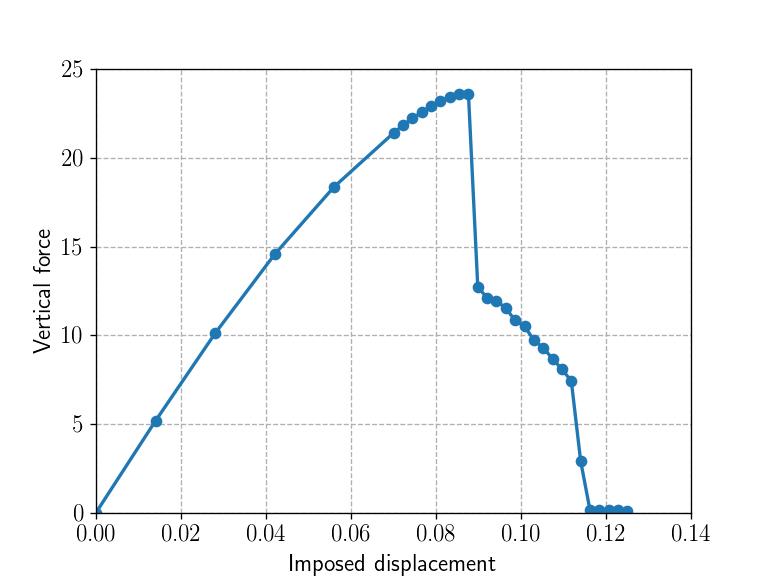

<IPython.core.display.Javascript object>


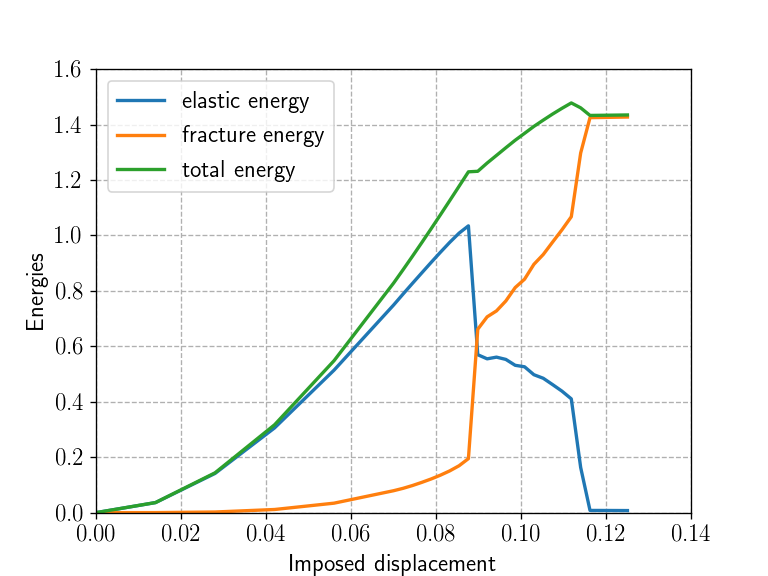

In [5]:
%matplotlib notebook

plt.figure()
plt.plot(loading, results[:, 0], "-o")
plt.xlabel("Imposed displacement")
plt.ylabel("Vertical force")
plt.show()

plt.figure()
plt.plot(loading, results[:, 1], label="elastic energy")
plt.plot(loading, results[:, 2], label="fracture energy")
plt.plot(loading, results[:, 1] + results[:, 2], label="total energy")
plt.xlabel("Imposed displacement")
plt.ylabel("Energies")
plt.legend()
plt.show()